In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pytz


In [2]:
# Load the dataset
data = pd.read_csv('SensorDataLTM.csv')

In [3]:
# Convert SensingDateTime(Hour) to datetime format
data['SensingDateTime(Hour)'] = pd.to_datetime(data['SensingDateTime(Hour)'], utc=True)


In [4]:
# Define the AEST timezone
aest = pytz.timezone('Australia/Sydney')

# Convert the datetime to AEST
data['SensingDateTime(Hour)'] = data['SensingDateTime(Hour)'].dt.tz_convert(aest)

In [5]:
# Extract useful components from the AEST datetime column
data['Year'] = data['SensingDateTime(Hour)'].dt.year
data['Month'] = data['SensingDateTime(Hour)'].dt.month
data['Day'] = data['SensingDateTime(Hour)'].dt.day
data['Hour'] = data['SensingDateTime(Hour)'].dt.hour
data['DayOfWeek'] = data['SensingDateTime(Hour)'].dt.dayofweek


In [6]:

# Set the datetime index for the time series decomposition with AEST
data.set_index('SensingDateTime(Hour)', inplace=True)


In [7]:
time_series_aest = data['Total_of_Directions'].resample('H').sum()

In [8]:
import numpy as np
from scipy.stats import linregress
# Generate the x values (numeric representation of the time index)
x = np.arange(len(time_series_aest))
y = time_series_aest.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the trend line
trend_line = intercept + slope * x

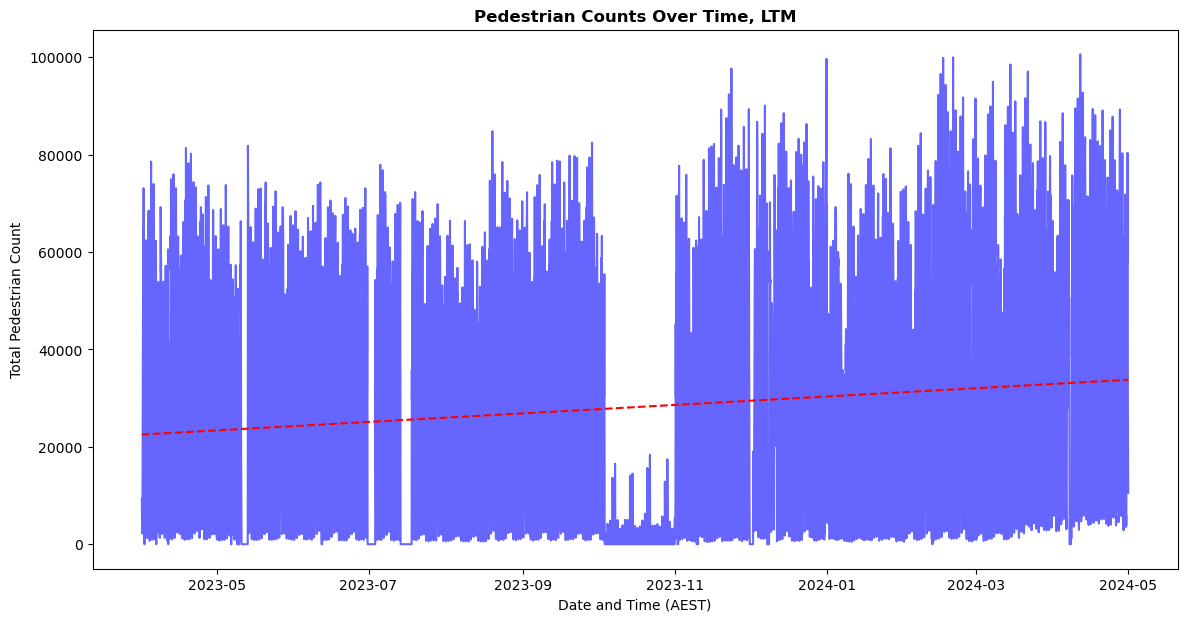

In [9]:
# Plot the time series of pedestrian counts in AEST
plt.figure(figsize=(14, 7))
plt.plot(time_series_aest, color='blue', alpha=0.6)
plt.plot(time_series_aest.index, trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Date and Time (AEST)')
plt.ylabel('Total Pedestrian Count')
plt.title('Pedestrian Counts Over Time, LTM',weight ="bold")
#plt.grid(True)
plt.show()

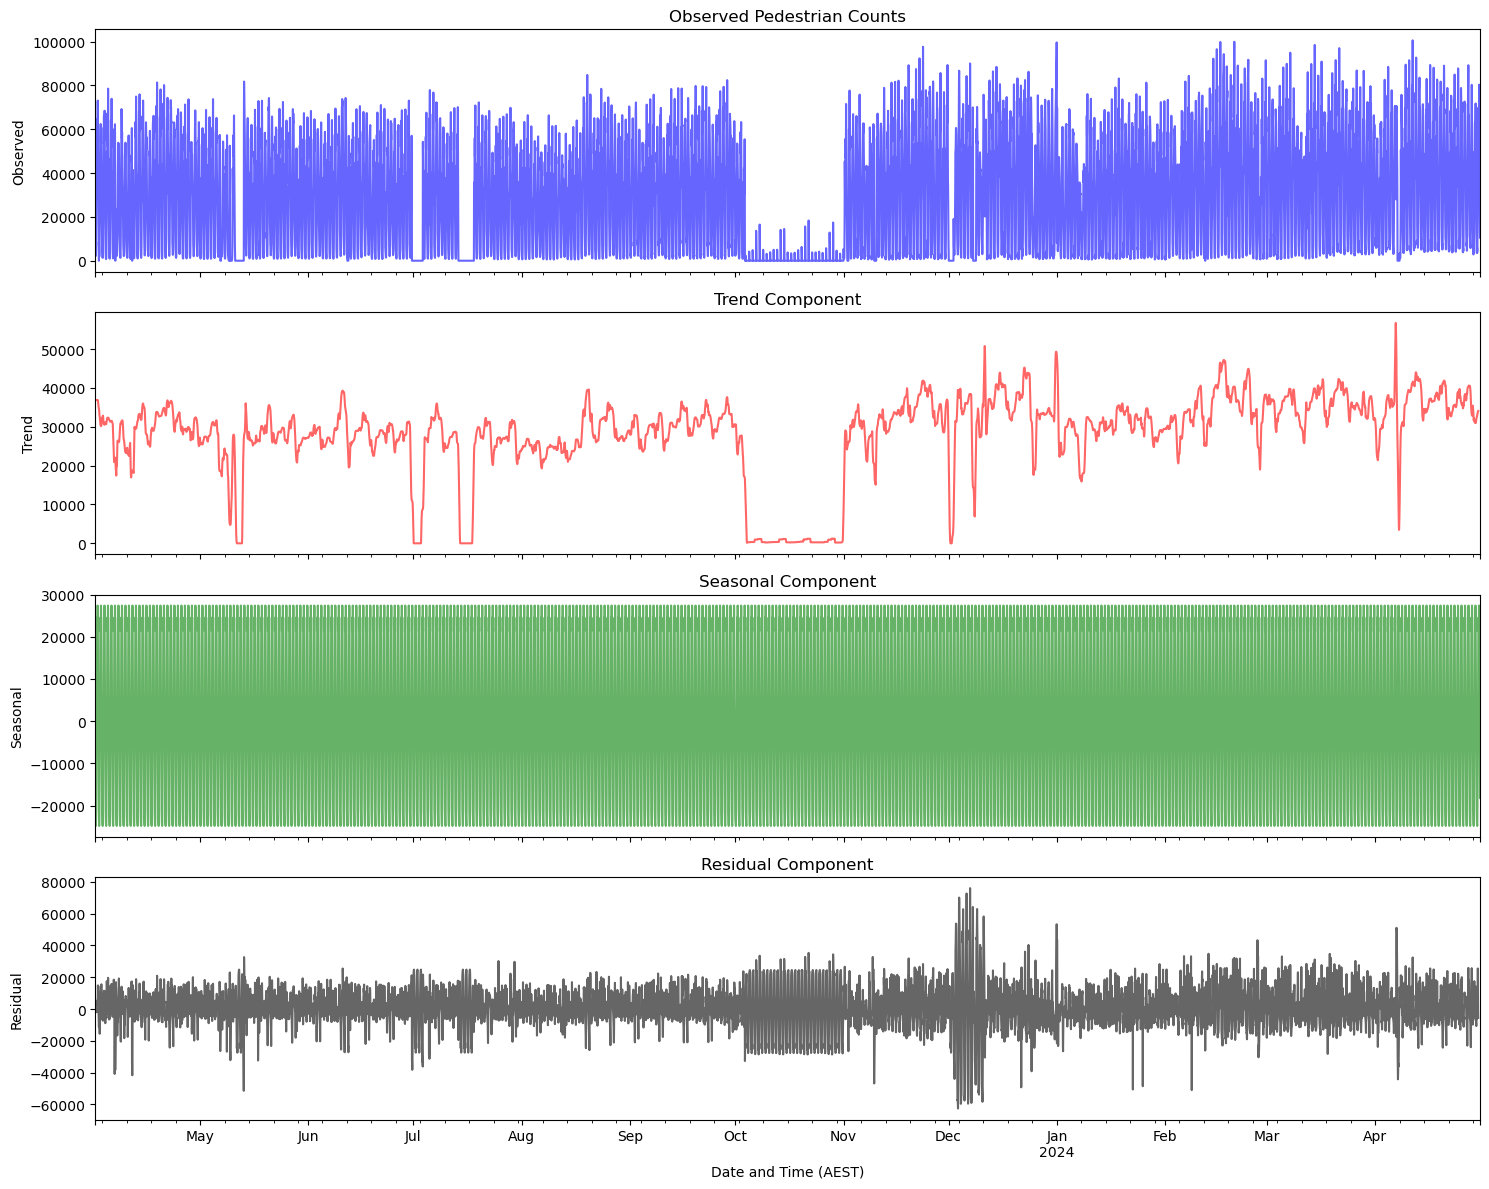

In [30]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(time_series_aest, model='additive')

# Plot the seasonal decomposition components
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

decomposition.observed.plot(ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Pedestrian Counts')

decomposition.trend.plot(ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Component')

decomposition.seasonal.plot(ax=axes[2], color='green', alpha=0.6)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Component')

decomposition.resid.plot(ax=axes[3], color='black', alpha=0.6)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Component')

plt.xlabel('Date and Time (AEST)')
plt.tight_layout()
plt.show()


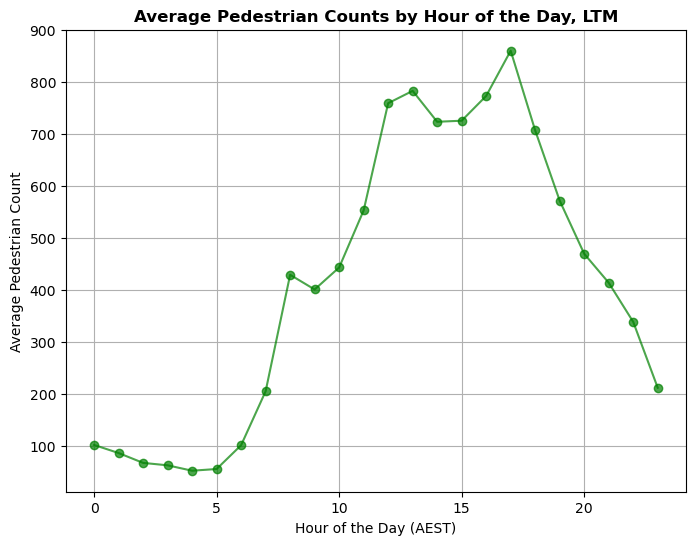

In [10]:
# Group by Hour and calculate the average pedestrian counts
hourly_counts_aest = data.groupby('Hour')['Total_of_Directions'].mean().reset_index()

# Plot average pedestrian counts by hour of the day
plt.figure(figsize=(8, 6))
plt.plot(hourly_counts_aest['Hour'], hourly_counts_aest['Total_of_Directions'], marker='o', linestyle='-', color='green', alpha=0.7)
plt.xlabel('Hour of the Day (AEST)')
plt.ylabel('Average Pedestrian Count')
plt.title('Average Pedestrian Counts by Hour of the Day, LTM',weight="bold")
plt.grid(True)
plt.show()

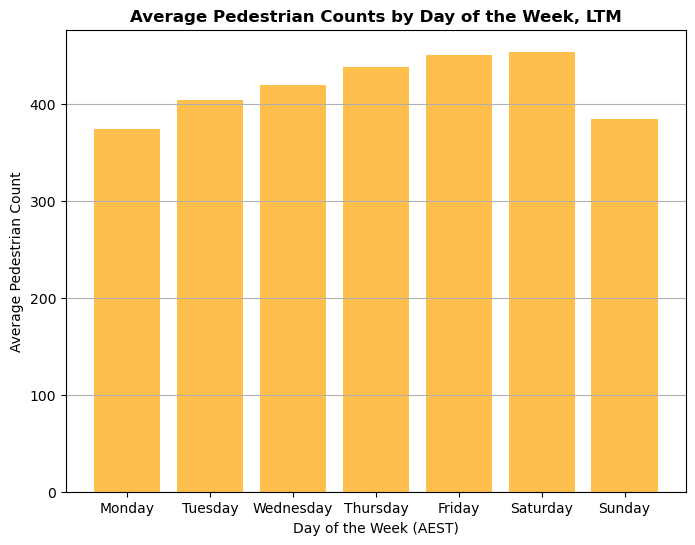

In [11]:
# Group by DayOfWeek and calculate the average pedestrian counts
daily_counts_aest = data.groupby('DayOfWeek')['Total_of_Directions'].mean().reset_index()
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
daily_counts_aest['DayName'] = daily_counts_aest['DayOfWeek'].map(day_names)

# Plot average pedestrian counts by day of the week
plt.figure(figsize=(8, 6))
plt.bar(daily_counts_aest['DayName'], daily_counts_aest['Total_of_Directions'], color='orange', alpha=0.7)
plt.xlabel('Day of the Week (AEST)')
plt.ylabel('Average Pedestrian Count')
plt.title('Average Pedestrian Counts by Day of the Week, LTM',weight='bold')
plt.grid(axis='y')
plt.show()

In [13]:
import folium

from folium.plugins import HeatMap


# Group by Sensor Description and sum the pedestrian counts
location_counts = data.groupby('Sensor_Description')['Total_of_Directions'].sum().reset_index()

# Extract latitude and longitude from Location_y column
data[['Latitude', 'Longitude']] = data['Location_y'].str.split(', ', expand=True)
data['Latitude'] = data['Latitude'].astype(float)
data['Longitude'] = data['Longitude'].astype(float)

# Merge the latitude and longitude back into location_counts
location_counts = location_counts.merge(
    data[['Sensor_Description', 'Latitude', 'Longitude']].drop_duplicates(),
    on='Sensor_Description',
    how='left'
)

# Create a map centered around a central point
map_center = [-37.8136, 144.9631]  # Melbourne CBD coordinates
m = folium.Map(location=map_center, zoom_start=14)

# Prepare data for the heatmap
heat_data = [
    [row['Latitude'], row['Longitude'], row['Total_of_Directions']]
    for _, row in location_counts.iterrows()
]

# Add the heatmap layer to the map
HeatMap(heat_data, radius=15).add_to(m)

# Save the map to an HTML file


# Display the map in a Jupyter Notebook (if using Jupyter)
m

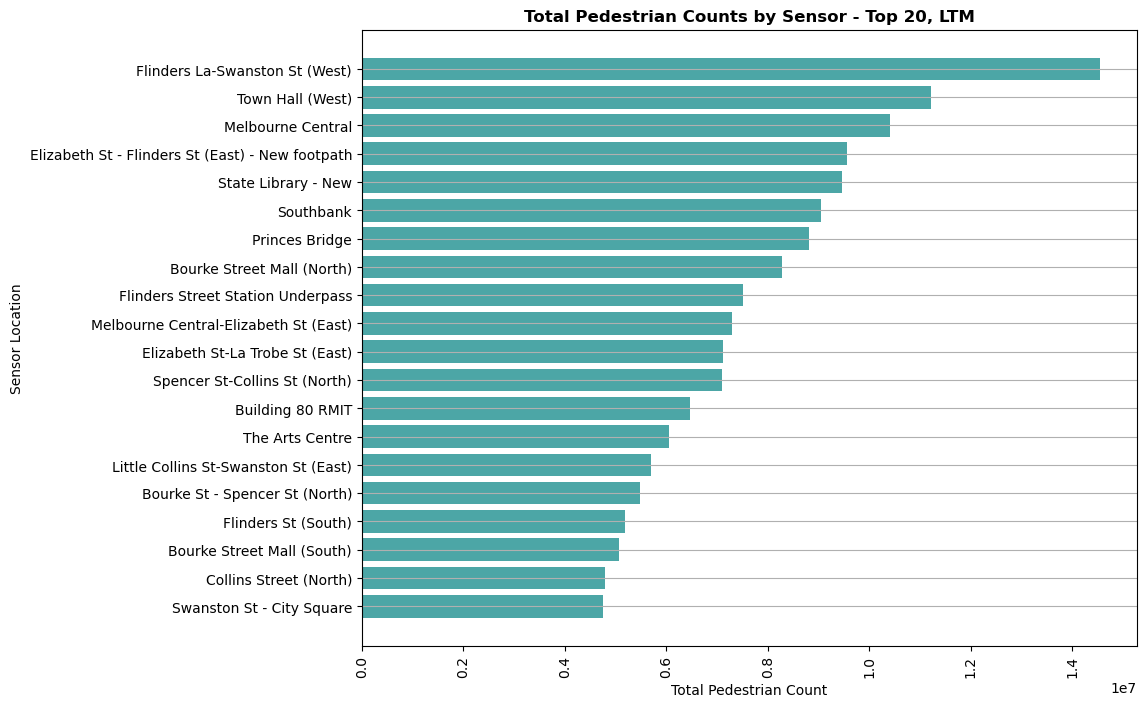

In [14]:
# Aggregate the data by sensor
sensor_aggregated = data.groupby(['Location_ID', 'Sensor_Description', 'Sensor_Name_x', 'Location_y'])['Total_of_Directions'].sum().reset_index()

# Sort sensors by total detections and get top 20
top_20_sensors = sensor_aggregated.sort_values(by='Total_of_Directions', ascending=False).head(20)

# Export top 20 sensors to CSV
#top_20_sensors.to_csv('/mnt/data/Top_20_sensors.csv', index=False)

# Sort the top 20 sensors by total detections in descending order for visualization
top_20_sensors = top_20_sensors.sort_values(by='Total_of_Directions', ascending=True)

# Plot total pedestrian counts by sensor location for the top 20 sensors
plt.figure(figsize=(10, 8))
plt.barh(top_20_sensors['Sensor_Description'], top_20_sensors['Total_of_Directions'], color='teal', alpha=0.7)
plt.xlabel('Total Pedestrian Count')
plt.ylabel('Sensor Location')
plt.title('Total Pedestrian Counts by Sensor - Top 20, LTM', weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


In [15]:
landmarks_data = pd.read_csv('landmarks-and-places-of-interest-including-schools-theatres-health-services-spor.csv')

In [16]:
from geopy.distance import geodesic
import matplotlib.colors as mcolors
# Group by Sensor Description and sum the pedestrian counts
location_counts = data.groupby('Sensor_Description')['Total_of_Directions'].sum().reset_index().head(20)

# Extract latitude and longitude from Location_y column
data[['Latitude', 'Longitude']] = data['Location_y'].str.split(', ', expand=True)
data['Latitude'] = data['Latitude'].astype(float)
data['Longitude'] = data['Longitude'].astype(float)

# Merge the latitude and longitude back into location_counts
location_counts = location_counts.merge(
    data[['Sensor_Description', 'Latitude', 'Longitude']].drop_duplicates(),
    on='Sensor_Description',
    how='left'
)

# Create a map centered around a central point with a lighter street view
map_center = [-37.8136, 144.9631]  # Melbourne CBD coordinates
m = folium.Map(location=map_center, zoom_start=14, tiles='CartoDB positron')

# Prepare data for the heatmap
heat_data = [
    [row['Latitude'], row['Longitude'], row['Total_of_Directions']]
    for _, row in location_counts.iterrows()
]

# Add the heatmap layer to the map
HeatMap(heat_data, radius=15).add_to(m)

# Define a color map for themes
unique_themes = landmarks_data['Theme'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_themes)).colors  # Using tab20 for more distinct colors
theme_colors = {theme: mcolors.rgb2hex(colors[i]) for i, theme in enumerate(unique_themes)}

# Add landmarks within 500 meters of any sensor to the same map with dot markers
for _, landmark in landmarks_data.iterrows():
    landmark_location = [float(coord) for coord in landmark['Co-ordinates'].split(', ')]
    for _, sensor in location_counts.iterrows():
        sensor_location = [sensor['Latitude'], sensor['Longitude']]
        if geodesic(sensor_location, landmark_location).meters <= 500:
            theme = landmark['Theme']
            folium.CircleMarker(
                location=landmark_location,
                radius=5,
                color=theme_colors[theme],
                fill=True,
                fill_color=theme_colors[theme],
                fill_opacity=1,
                popup=landmark['Feature Name']
            ).add_to(m)
            break

# Add a legend to the map
legend_html = '''
<div style="
    position: fixed;
    top: 10px; right: 10px; width: 150px; height: auto;
    border:2px solid grey; z-index:9999; font-size:10px;
    background-color:white; padding: 5px;">
    <b>Legend</b><br>
'''

for theme in unique_themes:
    legend_html += '''
    <i style="background-color:{}; border-radius:50%; width:10px; height:10px; display:inline-block;"></i>&nbsp;{}<br>
    '''.format(theme_colors[theme], theme)

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
#m.save('/mnt/data/lighter_street_view_heatmap_with_nearby_landmarks_and_legend.html')

# Display the map in a Jupyter Notebook (if using Jupyter)
m

C:\Users\hprag\AppData\Local\Temp\ipykernel_41848\810894354.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_themes)).colors  # Using tab20 for more distinct colors


In [17]:
# Prepare the data for counting landmarks by theme within 500 meters of each top 20 sensor
landmark_counts_by_theme = {theme: 0 for theme in unique_themes}

for _, landmark in landmarks_data.iterrows():
    landmark_location = [float(coord) for coord in landmark['Co-ordinates'].split(', ')]
    for _, sensor in location_counts.iterrows():
        sensor_location = [sensor['Latitude'], sensor['Longitude']]
        if geodesic(sensor_location, landmark_location).meters <= 500:
            landmark_counts_by_theme[landmark['Theme']] += 1
            break

# Convert the counts to a DataFrame for better visualization
landmark_counts_df = pd.DataFrame(list(landmark_counts_by_theme.items()), columns=['Theme', 'Count'])

# Sort the DataFrame by count in descending order
landmark_counts_df = landmark_counts_df.sort_values(by='Count', ascending=False)


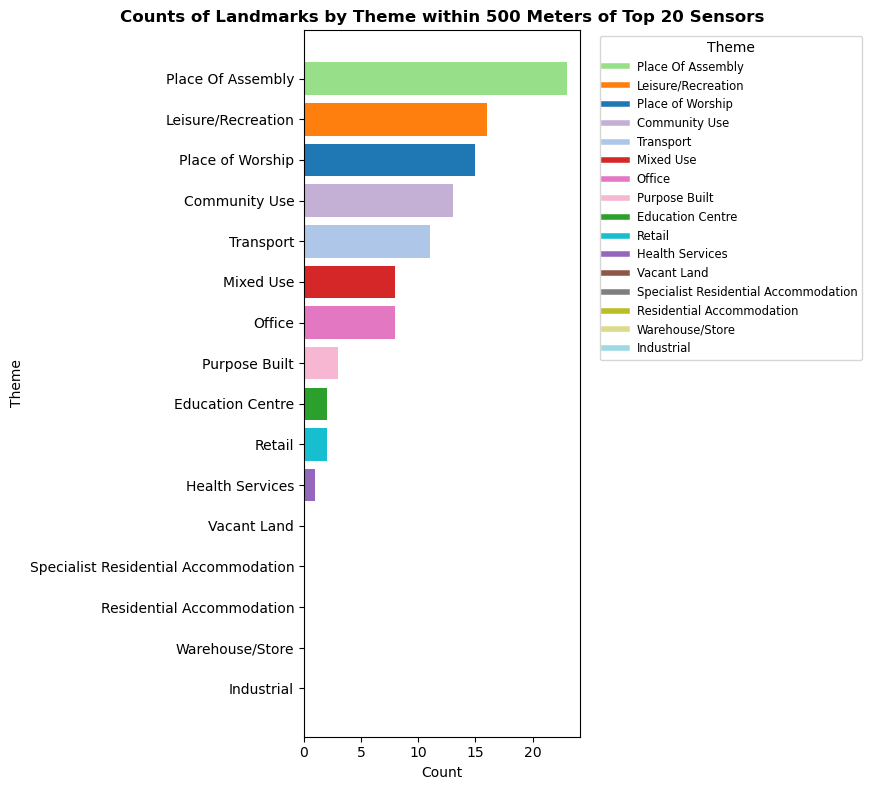

In [18]:
#landmark_counts_df = landmark_counts_df[landmark_counts_df['Count'] > 1]

# Plotting the counts of landmarks by theme within 500 meters of top 20 sensors using horizontal bars in descending order
plt.figure(figsize=(6,8 ))
bars = plt.barh(landmark_counts_df['Theme'], landmark_counts_df['Count'], color=[theme_colors[theme] for theme in landmark_counts_df['Theme']])
plt.title('Counts of Landmarks by Theme within 500 Meters of Top 20 Sensors',weight = "bold")
plt.xlabel('Count')
plt.ylabel('Theme')
plt.gca().invert_yaxis()  # Highest values at the top
plt.tight_layout()

# Adding the legend
legend_patches = [plt.Line2D([0], [0], color=theme_colors[theme], lw=4) for theme in landmark_counts_df['Theme']]
plt.legend(legend_patches, landmark_counts_df['Theme'], title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Show plot
plt.show()


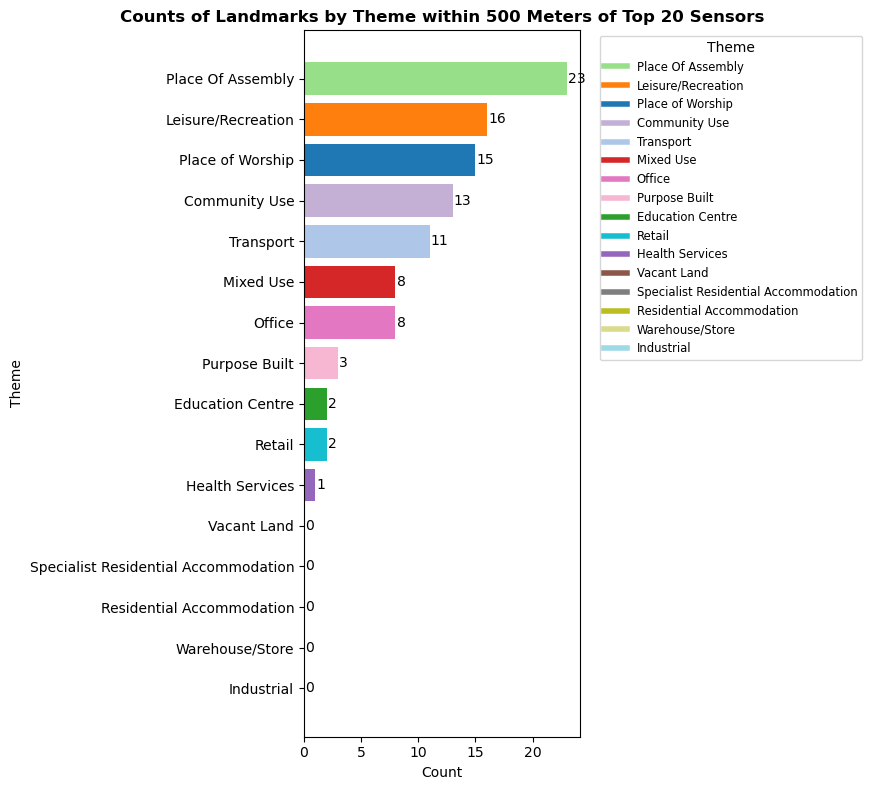

In [19]:
# Plotting the counts of landmarks by theme within 500 meters of top 20 sensors using horizontal bars in descending order
plt.figure(figsize=(6, 8))
bars = plt.barh(landmark_counts_df['Theme'], landmark_counts_df['Count'], color=[theme_colors[theme] for theme in landmark_counts_df['Theme']])
plt.title('Counts of Landmarks by Theme within 500 Meters of Top 20 Sensors', weight="bold")
plt.xlabel('Count')
plt.ylabel('Theme')
plt.gca().invert_yaxis()  # Highest values at the top
plt.tight_layout()

# Adding numbers on the bars
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', 
             va='center', ha='left', fontsize=10)

# Adding the legend
legend_patches = [plt.Line2D([0], [0], color=theme_colors[theme], lw=4) for theme in landmark_counts_df['Theme']]
plt.legend(legend_patches, landmark_counts_df['Theme'], title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Show plot
plt.show()


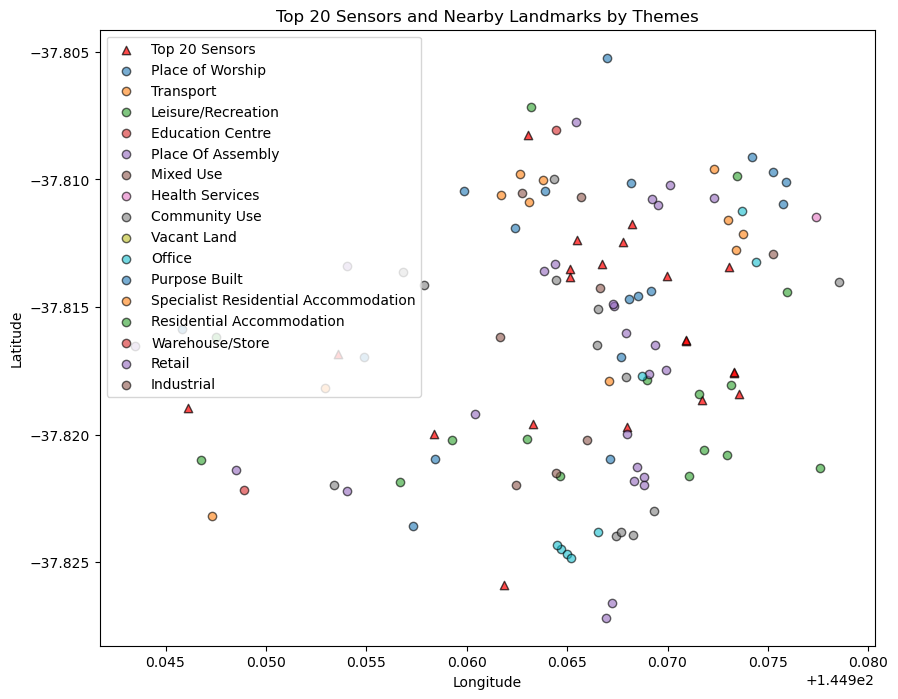

In [20]:
import matplotlib.pyplot as plt

# Prepare the data for scatter plot
nearby_landmarks = []

for _, landmark in landmarks_data.iterrows():
    landmark_location = [float(coord) for coord in landmark['Co-ordinates'].split(', ')]
    for _, sensor in location_counts.iterrows():
        sensor_location = [sensor['Latitude'], sensor['Longitude']]
        if geodesic(sensor_location, landmark_location).meters <= 500:
            nearby_landmarks.append({
                'Latitude': landmark_location[0],
                'Longitude': landmark_location[1],
                'Theme': landmark['Theme']
            })
            break

nearby_landmarks_df = pd.DataFrame(nearby_landmarks)

# Plotting
plt.figure(figsize=(10, 8))

# Plot sensors
plt.scatter(location_counts['Longitude'], location_counts['Latitude'], c='red', label='Top 20 Sensors', alpha=0.7, edgecolors='k', marker='^')

# Plot nearby landmarks with distinct colors for each theme
for theme in unique_themes:
    theme_data = nearby_landmarks_df[nearby_landmarks_df['Theme'] == theme]
    plt.scatter(theme_data['Longitude'], theme_data['Latitude'], label=theme, alpha=0.6, edgecolors='k')

# Adding titles and labels
plt.title('Top 20 Sensors and Nearby Landmarks by Themes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show plot
plt.show()
